## Загрузка и очистка данных


### Импорт всех необходимых в будущем библиотек

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

### Загрузка данных

In [112]:
orders = pd.read_csv("orders.csv")
visitors = pd.read_csv("visitors.csv")

### Очистка данных от некорректных значений

In [113]:
print("Пропуски")
print(orders.isna().sum())
print("\n")
print(visitors.isna().sum())
print("\n")
print("Дубликаты")
print(orders.duplicated().sum())
print("\n")
print(visitors.duplicated().sum())
print("\n")

Пропуски
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


date        0
group       0
visitors    0
dtype: int64


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Дубликаты
0


0


413


### Преобразование типов данных

In [114]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [115]:
orders["data"] = orders["date"].astype(np.datetime64)
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [116]:
visitors["date"]= visitors["date"].astype(np.datetime64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           243713 non-null  int64 
 1   EventName       243713 non-null  object
 2   DeviceIDHash    243713 non-null  int64 
 3   EventTimestamp  243713 non-null  int64 
 4   ExpId           243713 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.3+ MB


### Поиск пересекающихся пользователей

In [117]:
AGroup = orders[orders["group"] == "A"]
BGroup = orders[orders["group"] == "B"]
for aIter, aRow in  AGroup.iterrows():
    for bIter, bRow in BGroup.iterrows():
        if aRow["visitorId"] == bRow["visitorId"]:
            orders = orders.drop(orders[orders.visitorId == aRow["visitorId"]].index)


## Подготовка сводных таблиц, агреггированных данных и прочего.

### Агрегация данных

In [118]:
dateGroupPairs = orders[["date","group"]].drop_duplicates().reset_index()
dateGroupPairs = dateGroupPairs.drop("index",axis=1)

### Агрегация записей о заказаз по дате и группу
ordersAgg = dateGroupPairs.apply(
    lambda pair:
        orders[np.logical_and(
            orders["date"] == pair["date"],
            orders['group'] == pair["group"])
        ].agg({"date":"max",
                "group":"max",
                "transactionId":"nunique",
                "revenue":"sum",
                "visitorId":"nunique",}),
                axis=1
        ).sort_values(by=["date","group"]).reset_index().drop("index",axis=1)
### Агрегация данных о посетителях по дате и группе
visitorsAgg = dateGroupPairs.apply(
    lambda pair:
        visitors[np.logical_and(
            visitors["date"] == pair["date"],
            visitors['group'] == pair["group"])
            ].agg({"date":"max",
                    "group":"max",
                    "visitors":"sum"}),
                    axis=1
            ).sort_values(by=['date','group']).reset_index().drop("index",axis=1)
ordersAgg

,date,group,transactionId,revenue,visitorId
0,2019-08-01,A,23,142779,19
1,2019-08-01,B,17,59758,17
2,2019-08-02,A,19,91602,18
3,2019-08-02,B,23,162043,22
4,2019-08-03,A,24,112473,24
...,...,...,...,...,...
57,2019-08-29,B,15,106100,15
58,2019-08-30,A,9,78180,8
59,2019-08-30,B,21,209223,21
60,2019-08-31,A,8,53243,8


### Создаю общую таблицу для данных аггрегированных по дате и группу для заказов и посетителей

In [119]:
commonData = ordersAgg.drop(["date","group"],axis=1).join(visitors,sort=False)
commonData.rename(columns={"transactionId":"ordersCount","visitorId":"buyersCount"},inplace=True)
commonData = commonData[["date","group","ordersCount","buyersCount","revenue","visitors"]]
commonData

,date,group,ordersCount,buyersCount,visitors,revenue
0,2019-08-01,A,23,19,719,142779
1,2019-08-02,A,17,17,619,59758
2,2019-08-03,A,19,18,507,91602
3,2019-08-04,A,23,22,717,162043
4,2019-08-05,A,24,24,756,112473
...,...,...,...,...,...,...
57,2019-08-27,B,15,15,720,106100
58,2019-08-28,B,9,8,654,78180
59,2019-08-29,B,21,21,531,209223
60,2019-08-30,B,8,8,490,53243


## Выполнение задания по варианту  22(4)

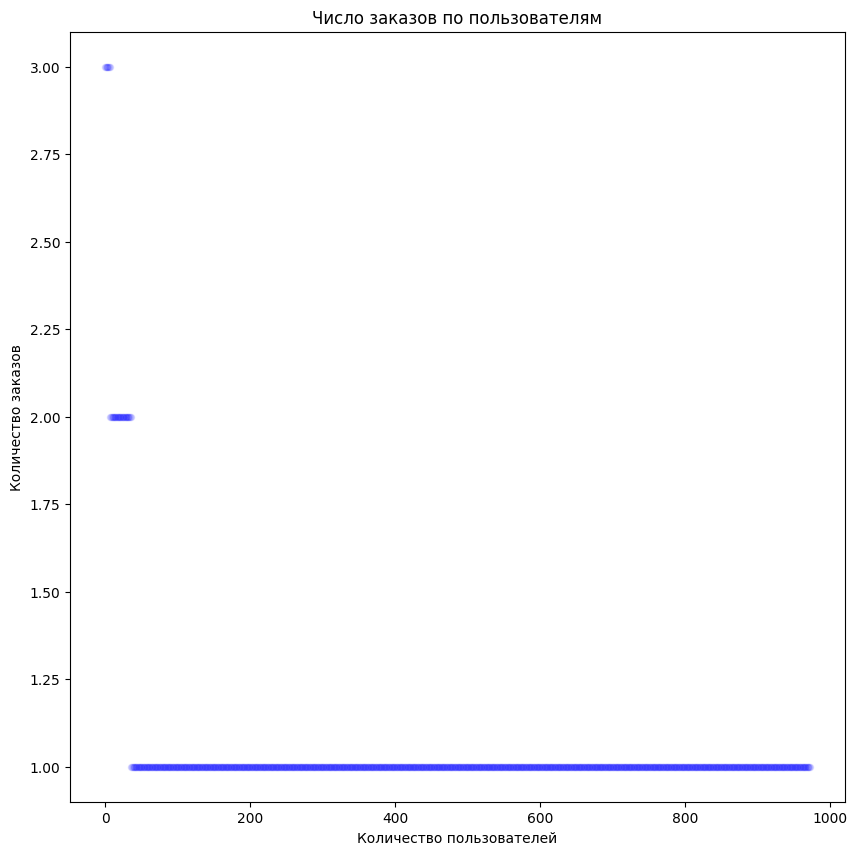

In [161]:
ordersByUser = orders.groupby(["visitorId"]).agg({"transactionId" :"nunique"}).rename(columns={"transactionId":"ordersCount"}).sort_values(by=["ordersCount"], ascending=False)
ordersByUser

fig, ax = plt.subplots()
x = pd.Series(range(0,len(ordersByUser)))
y = ordersByUser["ordersCount"]
plt.scatter(x,y,c= [[0,0,1,0.1]],s=20)
ax.set_title("Число заказов по пользователям")
fig.set_figwidth(10)
fig.set_figheight(10)
ax.set_xlabel("Количество пользователей")
ax.set_ylabel("Количество заказов")
plt.show()

### Выводы
Изходя из представленного выше графика видно, что большинство пользователей совершали заказ только один раз, небольшая часть сделала 2 заказа, и  только единицы сделали 3 заказа. Больше трех заказов не сделал ни один пользователь.

## 2 Часть задания

### Загрузка и очистка данных

In [166]:
logs_exp = pd.read_csv("logs_exp.csv",sep="\t")
print(logs_exp.isna().sum())
print(logs_exp.duplicated().sum())
logs_exp = logs_exp.drop_duplicates().reset_index().drop(columns=["index"],axis=1)
logs_exp

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
413


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247
243709,MainScreenAppear,5849806612437486590,1565212439,246
243710,MainScreenAppear,5746969938801999050,1565212483,246
243711,MainScreenAppear,5746969938801999050,1565212498,246


### Количество каждого события в порядке убывания

In [186]:

uniq = logs_exp["EventName"].unique()
count = [len(logs_exp[(logs_exp.EventName==u)]) for u in uniq]
eventCount = pd.DataFrame({"EventName":uniq,"Count":count}).sort_values(by=["Count"], ascending=False)
eventCount


,EventName,Count
0,MainScreenAppear,119101
3,OffersScreenAppear,46808
2,CartScreenAppear,42668
1,PaymentScreenSuccessful,34118
4,Tutorial,1018


Из таблицы выше видно, что наиболее частое действие у пользователей это MainScreenAppear

### Посчитать сколько пользователей совершали каждое из событий


In [187]:
print(logs_exp.groupby('EventName').agg({'DeviceIDHash': ['nunique']}))

                        DeviceIDHash
                             nunique
EventName                           
CartScreenAppear                3749
MainScreenAppear                7439
OffersScreenAppear              4613
PaymentScreenSuccessful         3547
Tutorial                         847


Больше всего пользователей у события MainScreenAppear (7439 пользователей).

### Определим кол-во пользователей в каждой группе

In [195]:
print(logs_exp.groupby("ExpId").agg({"DeviceIDHash": "nunique"}))

       DeviceIDHash
ExpId              
246            2489
247            2520
248            2542


### Пользователи, которые одновременно состоят в нескольких группах

In [203]:
data = logs_exp.groupby("DeviceIDHash").agg({"ExpId": "nunique"})
moreThanOne = len(data[(data.ExpId > 1)])
print(moreThanOne)


0


Не было найдено ни одного пользователя который бы состоял в более чем в одной группе одновременно

### Провести А/А Тест


In [223]:
import scipy
import math
def TestGroup(groupA,groupB,event,alpha):
    group_users = np.array([logs_exp.query('EventName == @event and ExpId == @groupA').DeviceIDHash.nunique(),
                            logs_exp.query('EventName == @event and ExpId == @groupB').DeviceIDHash.nunique()])
    #получим количество пользователей в группах
    total_users = np.array([logs_exp.query('ExpId == @groupA').DeviceIDHash.nunique(),
                            logs_exp.query('ExpId == @groupB').DeviceIDHash.nunique()])
    # пропорция успехов в первой группе:
    p1 = group_users[0]/total_users[0]
    # пропорция успехов во второй группе:
    p2 = group_users[1]/total_users[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (group_users[0] + group_users[1]) / (total_users[0] + total_users[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / total_users[0] + 1 / total_users[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1) 
    distr = scipy.stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть значимая разница между долями')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


#### Нулевая гипотеза: Группа 246 и 247 не имеет различий Альтернативная гипотеза: Группа 246 и 247 отличаются.

In [224]:
TestGroup(246,247,"CartScreenAppear",0.1)

p-значение:  0.19817540651836918
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [225]:
TestGroup(246,247,"MainScreenAppear",0.1)

p-значение:  0.5856639791209877
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [226]:
TestGroup(246,247,"OffersScreenAppear",0.1)

p-значение:  0.3233225048227193
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [227]:
TestGroup(246,247,"PaymentScreenSuccessful",0.1)

p-значение:  0.10902546202332886
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [228]:
TestGroup(246,247,"Tutorial",0.1)

p-значение:  0.8756574258016974
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для всех событий A/А тест не отверг нулевую гипотезу